# Hello, _nbpresent_!

In [ ]:
import nbpresent
nbpresent.__version__

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import datetime
figsize(12, 8)

Populating the interactive namespace from numpy and matplotlib


In [44]:
def massage_data(run):
    # Filter some nonsense values
    run.linuxtime = run.linuxtime.apply(datetime.datetime.fromtimestamp)
    run.rpm = run.rpm.apply(lambda x: x if x < 4000 and x >= 1 else np.nan)
    run.ds_volt = run.ds_volt.apply(lambda x: x if x < 400 and x > 100 else np.nan)
    run.ds_cur_48v = run.ds_cur_48v.apply(lambda x: x if x > 0 else np.nan)
    
    # Fill forward
    run.fillna(method='pad', inplace=True)
    
    run.set_index(run.linuxtime, drop=True, inplace=True)
    del run["linuxtime"]
    del run["time"]
#     del run["soc"]
    for col in run:
        run[col].index = run.index

    return run

In [45]:
run9 = pd.read_csv("test_logs/2016-07-01_run9.csv")
run9 = massage_data(run9)

run10 = pd.read_csv("test_logs/2016-07-01_run10.csv")
run10 = massage_data(run10)

# Combine the two
run = run9.append(run10)

## Rescale analog input to DeepSea Values
cur_fit = np.polyfit(run.an_cur_300v, run.ds_cur_300v, 1)
volt_fit = np.polyfit(run.an_volt, run.ds_volt, 1)
run.an_volt = run.an_volt * volt_fit[0] + volt_fit[1]
run.an_cur_300v = run.an_cur_300v * cur_fit[0] + cur_fit[1]

del run['ds_cur_48v']
run.head()

,rpm,ds_volt,ds_cur_300v,soc,ds_bat_cur,an_cur_300v,an_volt
linuxtime,,,,,,,
2016-07-01 13:55:31.340,2488.0,283.0,25.1,4.0,251.0,24.994841,283.213206
2016-07-01 13:55:31.450,2488.0,283.0,24.9,1.0,251.0,25.072473,283.261107
2016-07-01 13:55:31.560,2492.0,283.0,24.9,1.0,249.0,25.017379,283.117405
2016-07-01 13:55:31.680,2492.0,283.0,24.9,11.0,249.0,25.284084,283.192678
2016-07-01 13:55:31.780,2495.0,283.0,25.1,11.0,249.0,25.059952,283.206363


# BMS Data Stream
We collect the raw ASCII data stream from the Beckett BMS, so we have a black box of all the battery data, though the moment we're only reading State of Charge and Battery current into the primary log file.

# Overview

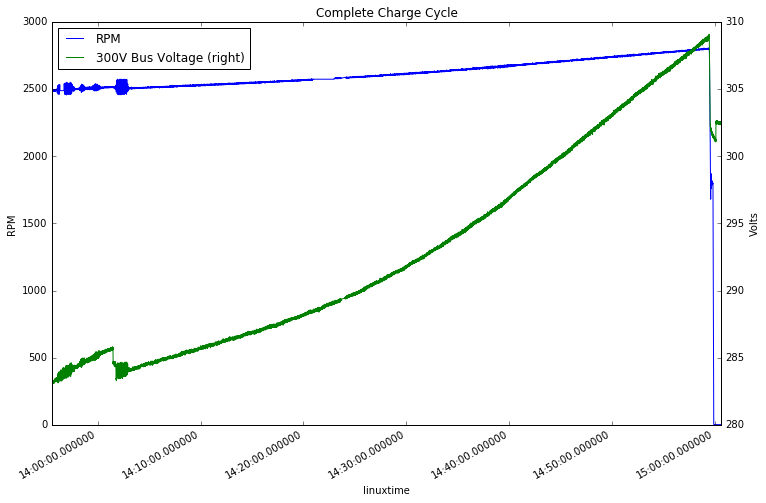

In [46]:
p = run.rpm.plot(label="RPM", legend=True)
p.set_ylabel("RPM")
p2 = run.an_volt.plot(label="300V Bus Voltage", legend=True, secondary_y=True)
p2.set_ylabel("Volts")
title("Complete Charge Cycle")

## Examine turnoff sequence

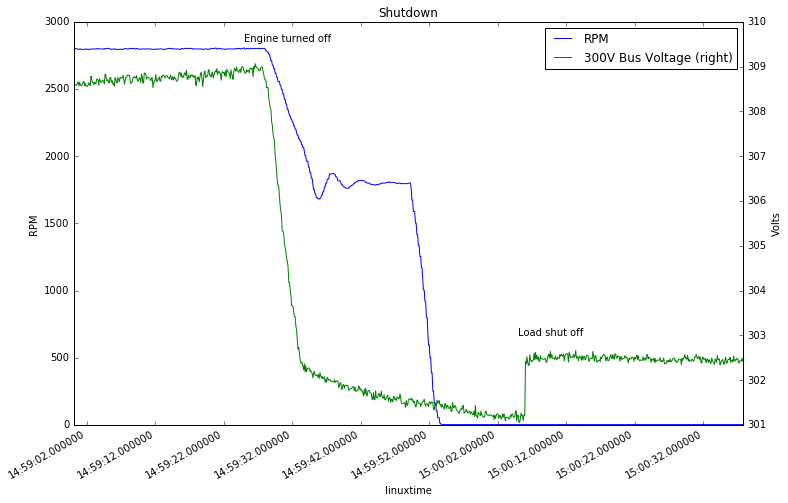

In [47]:
end = run["2016-07-01 14:59":"2016-07-01 15:00"]
p = end.rpm.plot(label="RPM", legend=True)
p.set_ylabel("RPM")
p2 = end.an_volt.plot(label="300V Bus Voltage", legend=True, secondary_y=True)
p2.set_ylabel("Volts")
title("Shutdown")
p.annotate('Engine turned off', ('2016-07-01 14:59:25', 2850))
p2.annotate('Load shut off', ('2016-07-01 15:00:05', 303))

# Examine resonance area

We saw some resonance coming in the Woodward control. We used the data we collected to determine at what load and RPM the resonance situation occured. The issue was resolved by better tuning the Woodward's control parameters.

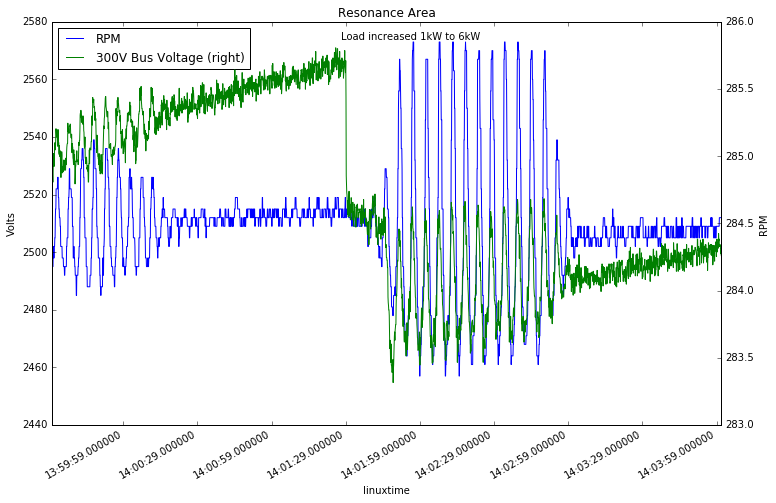

In [65]:
resonance = run["2016-07-01 13:59:30":"2016-07-01 14:04:00"]
prpm = resonance.rpm.plot(title="Resonance Area", label="RPM", legend=True)
pvolt = resonance.an_volt.plot(secondary_y=True, label="300V Bus Voltage", legend=True)
prpm.set_ylabel("Volts")
pvolt.annotate('Load increased 1kW to 6kW', ('2016-07-01 14:01:27', 285.87))
pvolt.set_ylabel("RPM")